In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

card_df = pd.read_csv("creditcard.csv")
card_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [2]:
from sklearn.model_selection import train_test_split

def get_preprocessed_df(df = None):
    df_copy = df.copy()
    df_copy.drop('Time', axis = 1, inplace = True)
    return df_copy

In [3]:
def get_train_test_dataset(df = None):
    df_copy = get_preprocessed_df(df)
    X_features = df_copy.iloc[:, :-1]
    y_target = df_copy.iloc[:, -1]
    
    X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size = 0.3, random_state = 0, stratify = y_target)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

In [4]:
print(y_train.value_counts() / y_train.shape[0] * 100)
print(y_test.value_counts() / y_test.shape[0] * 100)

0    99.827451
1     0.172549
Name: Class, dtype: float64
0    99.826785
1     0.173215
Name: Class, dtype: float64


In [7]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)[:, 1]

In [11]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
from sklearn.metrics import precision_recall_curve, roc_curve

def get_clf_eval(y_test, pred = None, pred_proba = None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred_proba)
    
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, f1 스코어: {3:.4f}, ROC-AUC score: {4:.4f}'\
          .format(accuracy, precision, recall, f1, roc_auc))

In [12]:
get_clf_eval(y_test, lr_pred, lr_pred_proba)

오차 행렬
[[85281    14]
 [   55    93]]
정확도: 0.9992, 정밀도: 0.8692, 재현율: 0.6284, f1 스코어: 0.7294, ROC-AUC score: 0.9650


In [13]:
def get_model_train_eval(model, ftr_train = None, ftr_test = None, tgt_train = None, tgt_test = None):
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:, 1]
    get_clf_eval(tgt_test, pred, pred_proba)

In [14]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators = 1000, num_leaves = 64, n_jobs = -1, boost_from_average = False)
get_model_train_eval(lgbm_clf, ftr_train = X_train,  ftr_test = X_test, tgt_train = y_train, tgt_test = y_test)

오차 행렬
[[85290     5]
 [   36   112]]
정확도: 0.9995, 정밀도: 0.9573, 재현율: 0.7568, f1 스코어: 0.8453, ROC-AUC score: 0.9790


<AxesSubplot:xlabel='Amount', ylabel='Density'>

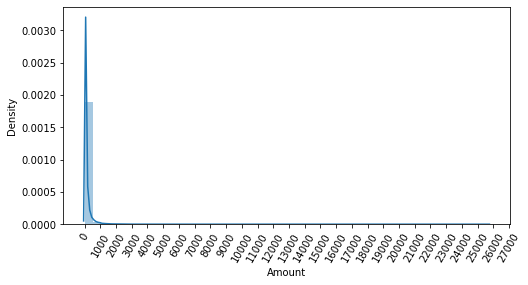

In [15]:
import seaborn as sns
plt.figure(figsize = (8, 4))
plt.xticks(range(0, 30000, 1000), rotation = 60)
sns.distplot(card_df['Amount'])

In [16]:
from sklearn.preprocessing import StandardScaler

def get_preprocessed_df(df = None):
    df_copy = df.copy()
    scaler = StandardScaler()
    amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1, 1))
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time', 'Amount'], axis = 1, inplace = True)
    return df_copy

In [18]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('로지스틱 회귀 예측 성능')
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, ftr_train = X_train,  ftr_test = X_test, tgt_train = y_train, tgt_test = y_test)

print('LGBM 예측 성능')
lgbm_clf = LGBMClassifier(n_estimators = 1000, num_leaves = 64, n_jobs = -1, boost_from_average = False)
get_model_train_eval(lgbm_clf, ftr_train = X_train,  ftr_test = X_test, tgt_train = y_train, tgt_test = y_test)

로지스틱 회귀 예측 성능
오차 행렬
[[85281    14]
 [   58    90]]
정확도: 0.9992, 정밀도: 0.8654, 재현율: 0.6081, f1 스코어: 0.7143, ROC-AUC score: 0.9702
LGBM 예측 성능
오차 행렬
[[85290     5]
 [   37   111]]
정확도: 0.9995, 정밀도: 0.9569, 재현율: 0.7500, f1 스코어: 0.8409, ROC-AUC score: 0.9779


In [19]:
def get_preprocessed_df(df = None):
    df_copy = df.copy()
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time', 'Amount'], axis = 1, inplace = True)
    return df_copy

In [20]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('로지스틱 회귀 예측 성능')
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, ftr_train = X_train,  ftr_test = X_test, tgt_train = y_train, tgt_test = y_test)

print('LGBM 예측 성능')
lgbm_clf = LGBMClassifier(n_estimators = 1000, num_leaves = 64, n_jobs = -1, boost_from_average = False)
get_model_train_eval(lgbm_clf, ftr_train = X_train,  ftr_test = X_test, tgt_train = y_train, tgt_test = y_test)

로지스틱 회귀 예측 성능
오차 행렬
[[85283    12]
 [   59    89]]
정확도: 0.9992, 정밀도: 0.8812, 재현율: 0.6014, f1 스코어: 0.7149, ROC-AUC score: 0.9727
LGBM 예측 성능
오차 행렬
[[85290     5]
 [   35   113]]
정확도: 0.9995, 정밀도: 0.9576, 재현율: 0.7635, f1 스코어: 0.8496, ROC-AUC score: 0.9796


<AxesSubplot:>

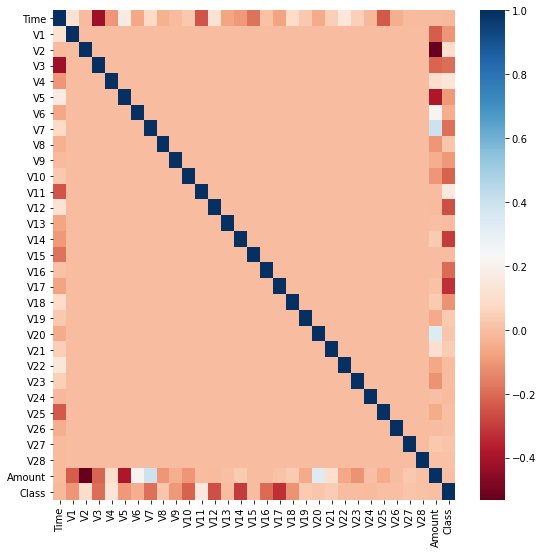

In [21]:
plt.figure(figsize = (9, 9))
corr = card_df.corr()
sns.heatmap(corr, cmap = 'RdBu')

In [22]:
def get_outlier(df = None, column = None, weight = 1.5):
    fraud = df[df['Class'] == 1][column]
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_75 = np.percentile(fraud.values, 75)
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight
    
    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index
    return outlier_index

In [23]:
outlier_index = get_outlier(df = card_df, column = 'V14', weight = 1.5)
print('이상치 데이터 인덱스: ', outlier_index)

이상치 데이터 인덱스:  Int64Index([8296, 8615, 9035, 9252], dtype='int64')


In [24]:
def get_preprocessed_df(df = None):
    df_copy = df.copy()
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time', 'Amount'], axis = 1, inplace = True)
    
    outlier_index = get_outlier(df = card_df, column = 'V14', weight = 1.5)
    df_copy.drop(outlier_index, axis = 0, inplace = True)
    
    return df_copy

In [25]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('로지스틱 회귀 예측 성능')
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, ftr_train = X_train,  ftr_test = X_test, tgt_train = y_train, tgt_test = y_test)

print('LGBM 예측 성능')
lgbm_clf = LGBMClassifier(n_estimators = 1000, num_leaves = 64, n_jobs = -1, boost_from_average = False)
get_model_train_eval(lgbm_clf, ftr_train = X_train,  ftr_test = X_test, tgt_train = y_train, tgt_test = y_test)

로지스틱 회귀 예측 성능
오차 행렬
[[85281    14]
 [   48    98]]
정확도: 0.9993, 정밀도: 0.8750, 재현율: 0.6712, f1 스코어: 0.7597, ROC-AUC score: 0.9743
LGBM 예측 성능
오차 행렬
[[85290     5]
 [   25   121]]
정확도: 0.9996, 정밀도: 0.9603, 재현율: 0.8288, f1 스코어: 0.8897, ROC-AUC score: 0.9780


In [26]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state = 0)
X_train_over, y_train_over = smote.fit_sample(X_train, y_train)
print(X_train.shape, y_train.shape)
print(X_train_over.shape, y_train_over.shape)

(199362, 29) (199362,)
(398040, 29) (398040,)


In [27]:
print(pd.Series(y_train_over).value_counts())

0    199020
1    199020
Name: Class, dtype: int64


In [28]:
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, ftr_train = X_train_over,  ftr_test = X_test, tgt_train = y_train_over, tgt_test = y_test)

오차 행렬
[[82937  2358]
 [   11   135]]
정확도: 0.9723, 정밀도: 0.0542, 재현율: 0.9247, f1 스코어: 0.1023, ROC-AUC score: 0.9737


In [44]:
def precision_recall_curve_plot(y_test, pred_proba_c1):
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    plt.figure(figsize = (8, 6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle = '--', label = 'precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label = 'recall')
    
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    plt.xlabel('threshold value'); plt.ylabel('precision and recall value')
    plt.legend(); plt.grid()
    plt.show()

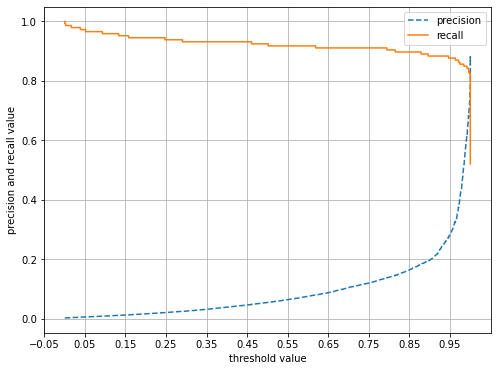

In [45]:
precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:, 1])

In [46]:
lgbm_clf = LGBMClassifier(n_estimators = 1000, num_leaves = 64, n_jobs = -1, boost_from_average = False)
get_model_train_eval(lgbm_clf, ftr_train = X_train_over,  ftr_test = X_test, tgt_train = y_train_over, tgt_test = y_test)

오차 행렬
[[85283    12]
 [   22   124]]
정확도: 0.9996, 정밀도: 0.9118, 재현율: 0.8493, f1 스코어: 0.8794, ROC-AUC score: 0.9814
